# **DengAI: Predicting Disease Spread**


In this Notebook.SARIMAX was used tho predict the dengue cases from the dengue_features_test file for submission in DengAI competition

In [ ]:
#Import necessary libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np




##Reading Data


In [ ]:
#import pandas as pd
train_df = pd.read_csv("dengue_features_train.csv")
label_df= pd.read_csv("dengue_labels_train.csv")
test_df = pd.read_csv("dengue_features_test.csv")
submission = pd.read_csv("submission_format.csv",index_col=[0, 1, 2])

In [ ]:
# Create copies of the original DataFrames
df = train_df.copy()
df_label = label_df.copy()
df_test = test_df.copy()

In [ ]:
print("train_df", df.shape)
print("label_df", df_label.shape)
print("test_df", df_test.shape)

train_df (1456, 24)
label_df (1456, 4)
test_df (416, 24)


## Data Preprocessing

In [ ]:
def preprocess_data(data_path, labels_path=None):
    # load data
    df = pd.read_csv(data_path)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path)
        df = df.merge(labels['total_cases'], left_index=True, right_index=True)

    # Convert 'week_start_date' to datetime format and get the first date
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    start_date = df['week_start_date'].iloc[0]

    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # separate san juan and iquitos
    sj = df[df['city'] == 'sj'].drop('city', axis=1)
    iq = df[df['city'] == 'iq'].drop('city', axis=1)

    sj_len = len(sj)
    iq_len = len(iq)

    sj_dates = pd.date_range(start=start_date, periods=sj_len, freq='7D')
    iq_dates = pd.date_range(start=start_date, periods=iq_len, freq='7D')

    sj.set_index(sj_dates, inplace=True)
    iq.set_index(iq_dates, inplace=True)

    sj.index.freq = '7D'
    iq.index.freq = '7D'

    return sj, iq

### Preprocess data for train data and label data

In [ ]:
# Preprocess data for train data and label
sj_data, iq_data = preprocess_data(data_path = "dengue_features_train.csv", labels_path= "dengue_labels_train.csv")

In [ ]:
print("sj_data", sj_data.shape)
print("iq_data", iq_data.shape)

sj_data (936, 24)
iq_data (520, 24)


In [ ]:
sj_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 936 entries, 1990-04-30 to 2008-03-31
Freq: 7D
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   year                                   936 non-null    int64         
 1   weekofyear                             936 non-null    int64         
 2   week_start_date                        936 non-null    datetime64[ns]
 3   ndvi_ne                                936 non-null    float64       
 4   ndvi_nw                                936 non-null    float64       
 5   ndvi_se                                936 non-null    float64       
 6   ndvi_sw                                936 non-null    float64       
 7   precipitation_amt_mm                   936 non-null    float64       
 8   reanalysis_air_temp_k                  936 non-null    float64       
 9   reanalysis_avg_temp_k                

In [ ]:
sj_data.isna().sum()

year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

In [ ]:
iq_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520 entries, 1990-04-30 to 2000-04-10
Freq: 7D
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   year                                   520 non-null    int64         
 1   weekofyear                             520 non-null    int64         
 2   week_start_date                        520 non-null    datetime64[ns]
 3   ndvi_ne                                520 non-null    float64       
 4   ndvi_nw                                520 non-null    float64       
 5   ndvi_se                                520 non-null    float64       
 6   ndvi_sw                                520 non-null    float64       
 7   precipitation_amt_mm                   520 non-null    float64       
 8   reanalysis_air_temp_k                  520 non-null    float64       
 9   reanalysis_avg_temp_k                

In [ ]:
iq_data.isna().sum()

year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

### Preprocess data for test data

In [ ]:
# Preprocess datafor test data
sj_test_data, iq_test_data = preprocess_data(data_path = "dengue_features_test.csv")

In [ ]:
print("sj_test_data", sj_test_data.shape)
print("iq_test_data", iq_test_data.shape)

sj_test_data (260, 23)
iq_test_data (156, 23)


In [ ]:
sj_test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2008-04-29 to 2013-04-16
Freq: 7D
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   year                                   260 non-null    int64         
 1   weekofyear                             260 non-null    int64         
 2   week_start_date                        260 non-null    datetime64[ns]
 3   ndvi_ne                                260 non-null    float64       
 4   ndvi_nw                                260 non-null    float64       
 5   ndvi_se                                260 non-null    float64       
 6   ndvi_sw                                260 non-null    float64       
 7   precipitation_amt_mm                   260 non-null    float64       
 8   reanalysis_air_temp_k                  260 non-null    float64       
 9   reanalysis_avg_temp_k                

In [ ]:
sj_test_data.isna().sum()

year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [ ]:
iq_test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2008-04-29 to 2011-04-19
Freq: 7D
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   year                                   156 non-null    int64         
 1   weekofyear                             156 non-null    int64         
 2   week_start_date                        156 non-null    datetime64[ns]
 3   ndvi_ne                                156 non-null    float64       
 4   ndvi_nw                                156 non-null    float64       
 5   ndvi_se                                156 non-null    float64       
 6   ndvi_sw                                156 non-null    float64       
 7   precipitation_amt_mm                   156 non-null    float64       
 8   reanalysis_air_temp_k                  156 non-null    float64       
 9   reanalysis_avg_temp_k                

In [ ]:
iq_test_data.isna().sum()

year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

##SARIMAX


###Modelling and making predictions for San Juan with three features


Features:
- precipitation_amt_mm
- station_max_temp_c
- station_min_temp_c

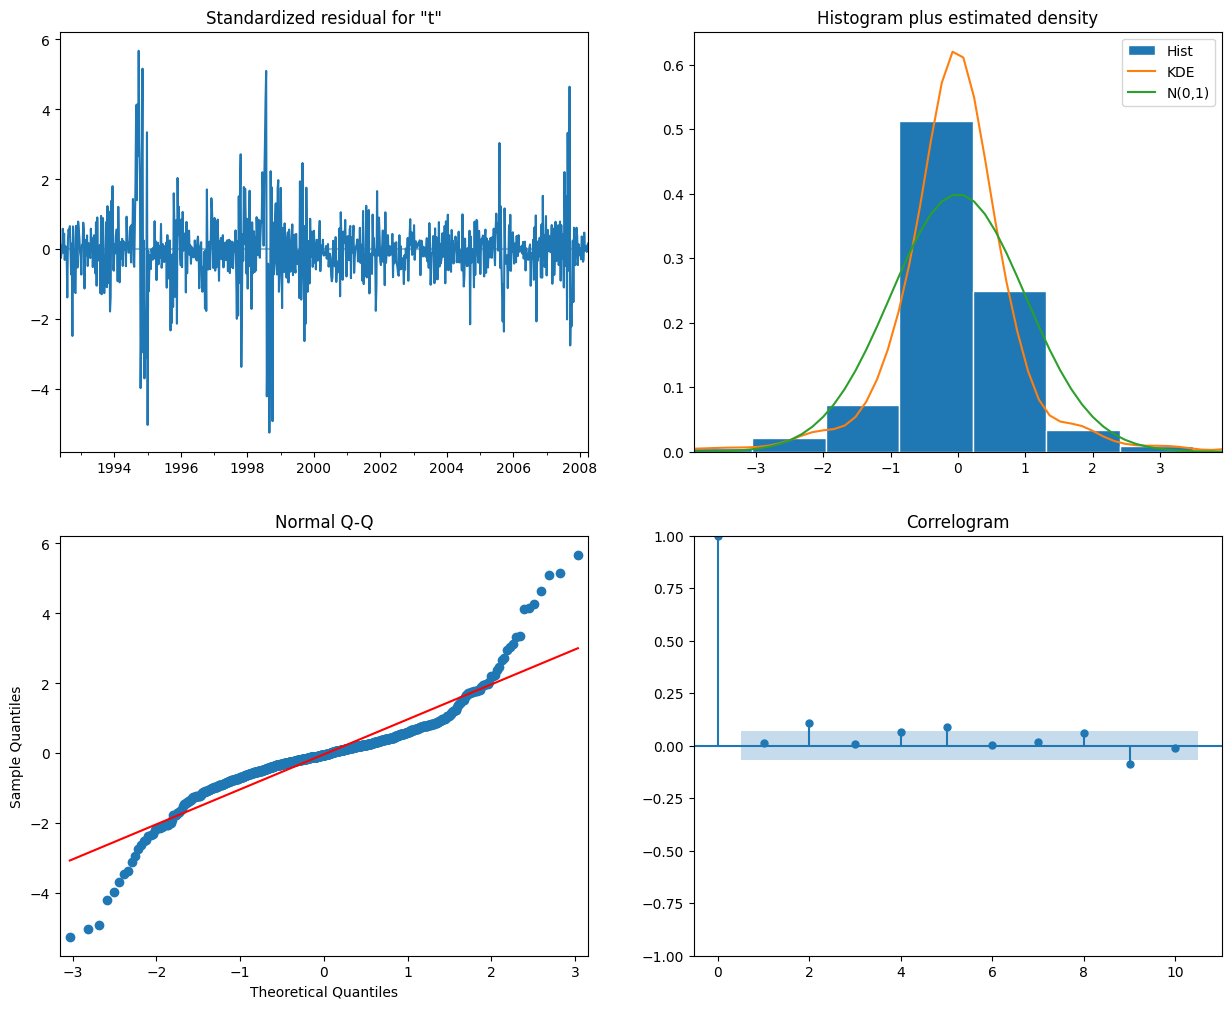

                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  936
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -3380.266
Date:                            Wed, 14 Feb 2024   AIC                           6774.532
Time:                                    17:02:14   BIC                           6807.582
Sample:                                04-30-1990   HQIC                          6787.206
                                     - 03-31-2008                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
precipitation_amt_mm    -0.0050      0.008     -0.590      0.555      -0.022       0.012
stati

In [ ]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initial model order parameters
p = 1  # AR term
d = 0  # Differencing term, assuming the series is stationary
q = 1 # MA term, starting value based on ACF plot
P = 0 # Seasonal AR term (previous 1)
D = 1 # Seasonal differencing term, to account for the clear seasonal pattern observed
Q = 1 # Seasonal MA term
s = 52  # Seasonal period (weekly data)

# Fit the SARIMAX model
sj_model = SARIMAX(endog=sj_data['total_cases'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=sj_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]],
                enforce_stationarity=False,
                enforce_invertibility=False)

sj_results = sj_model.fit()

sj_results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Summary of the model to check for significant coefficients and good model fit
print(sj_results.summary())


Perform prediction for sj_data

In [ ]:
sj_data.index

DatetimeIndex(['1990-04-30', '1990-05-07', '1990-05-14', '1990-05-21',
               '1990-05-28', '1990-06-04', '1990-06-11', '1990-06-18',
               '1990-06-25', '1990-07-02',
               ...
               '2008-01-28', '2008-02-04', '2008-02-11', '2008-02-18',
               '2008-02-25', '2008-03-03', '2008-03-10', '2008-03-17',
               '2008-03-24', '2008-03-31'],
              dtype='datetime64[ns]', length=936, freq='7D')

In [ ]:
# Set the start and end index for prediction
start_index = '1990-04-30'
end_index = '2008-03-31'

# Define the exogenous variables for future predictions
future_exog = sj_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]]

# Perform prediction for sj_data
sj_data_prediction= sj_results.get_prediction(start=start_index,
                                                  end=end_index,
                                                  exog=future_exog)

# Get the predicted mean for sj_data
sj_data_prediction_mean = sj_data_prediction.predicted_mean


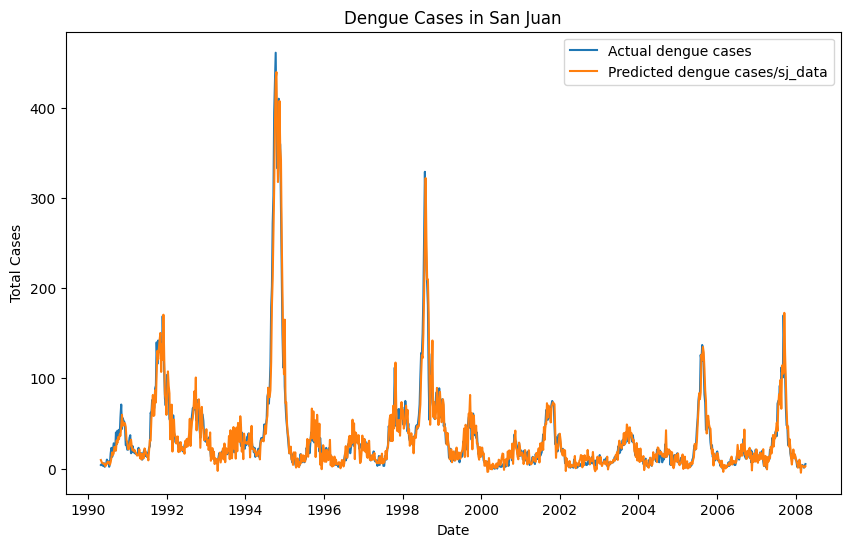

In [ ]:
# Plotting predicted and actual dengue cases from sj_data
plt.figure(figsize=(10, 6))
plt.plot(sj_data.total_cases, label='Actual dengue cases')
plt.plot(sj_data_prediction_mean, label='Predicted dengue cases/sj_data')  # Plot predicted values
plt.title('Dengue Cases in San Juan')                 # Set title
plt.xlabel('Date')                                    # Set x-axis label
plt.ylabel('Total Cases')                             # Set y-axis label
plt.legend()                                          # Show legend
plt.show()                                            # Display plot


Perform prediction for sj_test_data

In [ ]:
sj_test_data.index

DatetimeIndex(['2008-04-29', '2008-05-06', '2008-05-13', '2008-05-20',
               '2008-05-27', '2008-06-03', '2008-06-10', '2008-06-17',
               '2008-06-24', '2008-07-01',
               ...
               '2013-02-12', '2013-02-19', '2013-02-26', '2013-03-05',
               '2013-03-12', '2013-03-19', '2013-03-26', '2013-04-02',
               '2013-04-09', '2013-04-16'],
              dtype='datetime64[ns]', length=260, freq='7D')

In [ ]:
# Define the exogenous variables for future predictions
future_exog = sj_test_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]]

# Perform prediction for sj_data
sj_test_data_prediction= sj_results.get_forecast(steps=260, exog=future_exog)

# Get the predicted mean for sj_data
sj_test_data_prediction_mean = sj_test_data_prediction.predicted_mean

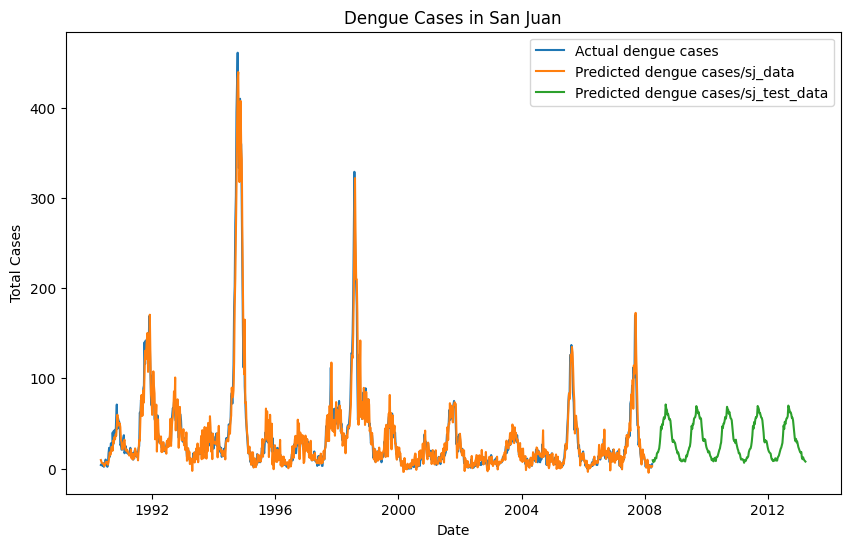

In [ ]:
# Plotting predicted and actual dengue cases from sj_data and sj_test_data
plt.figure(figsize=(10, 6))
plt.plot(sj_data.total_cases, label='Actual dengue cases')        # Plot actual values
plt.plot(sj_data_prediction_mean, label='Predicted dengue cases/sj_data')  # Plot predicted values
plt.plot(sj_test_data_prediction_mean, label='Predicted dengue cases/sj_test_data')
plt.title('Dengue Cases in San Juan')                 # Set title
plt.xlabel('Date')                                    # Set x-axis label
plt.ylabel('Total Cases')                             # Set y-axis label
plt.legend()                                          # Show legend
plt.show()                                            # Display plot


### Modelling and making predictions for Iquitos with three features


Features:
- precipitation_amt_mm
- station_max_temp_c
- station_min_temp_c

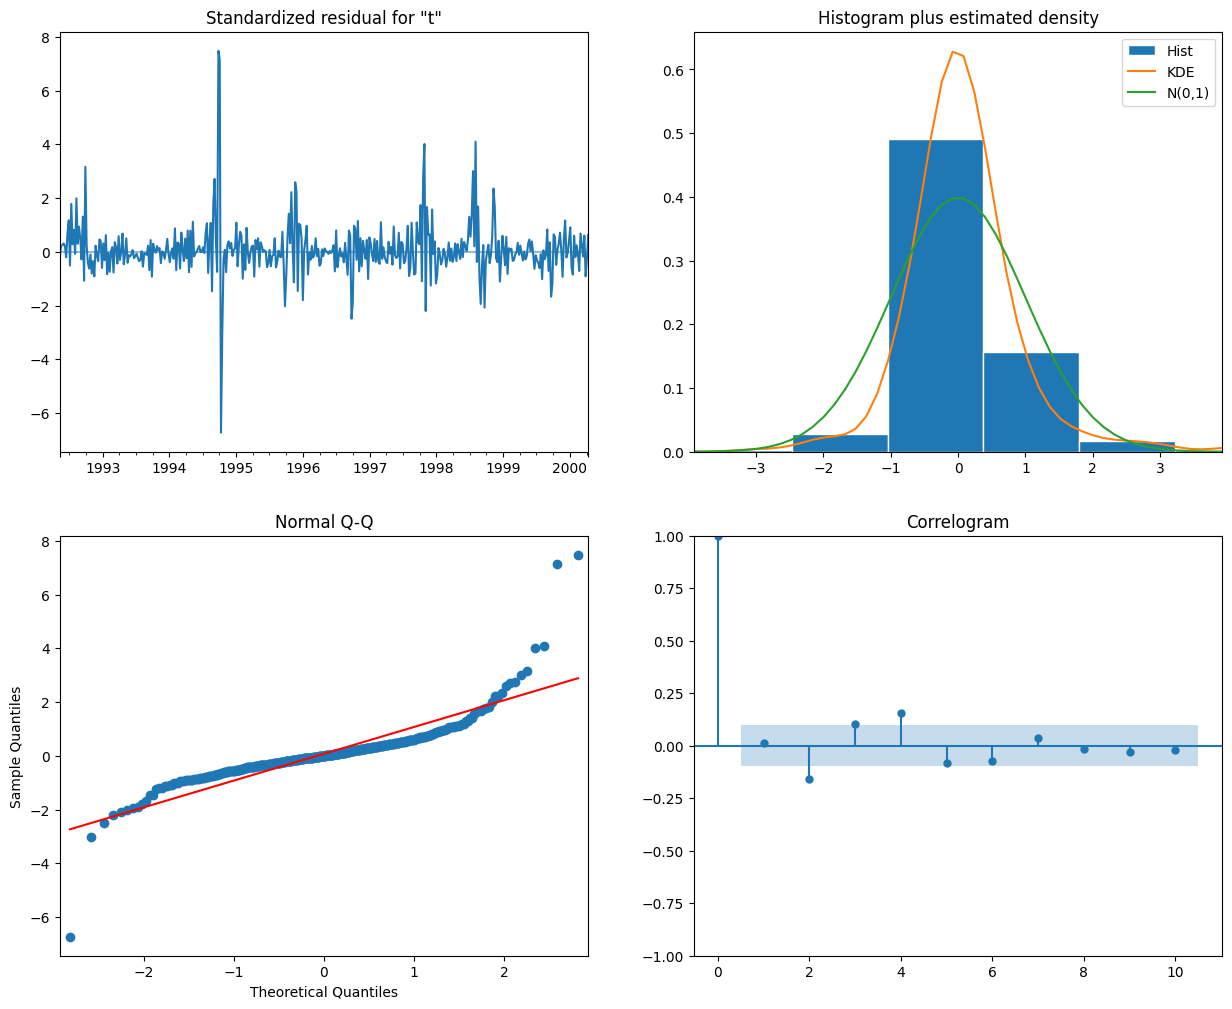

                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  520
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1443.070
Date:                            Wed, 14 Feb 2024   AIC                           2900.140
Time:                                    17:40:23   BIC                           2928.321
Sample:                                04-30-1990   HQIC                          2911.285
                                     - 04-10-2000                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
precipitation_amt_mm     0.0015      0.014      0.111      0.912      -0.026       0.029
stati

In [ ]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initial model order parameters
p = 1  # AR term
d = 0  # Differencing term, assuming the series is stationary
q = 1 # MA term, starting value based on ACF plot
P = 0 # Seasonal AR term (previous 1)
D = 1 # Seasonal differencing term, to account for the clear seasonal pattern observed
Q = 1 # Seasonal MA term
s = 52  # Seasonal period (weekly data)

# Fit the SARIMAX model
iq_model = SARIMAX(endog=iq_data['total_cases'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=iq_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]],
                enforce_stationarity=False,
                enforce_invertibility=False)

iq_results = iq_model.fit()

iq_results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Summary of the model to check for significant coefficients and good model fit
print(iq_results.summary())

Perform prediction for iq_data

In [ ]:
iq_data.index

DatetimeIndex(['1990-04-30', '1990-05-07', '1990-05-14', '1990-05-21',
               '1990-05-28', '1990-06-04', '1990-06-11', '1990-06-18',
               '1990-06-25', '1990-07-02',
               ...
               '2000-02-07', '2000-02-14', '2000-02-21', '2000-02-28',
               '2000-03-06', '2000-03-13', '2000-03-20', '2000-03-27',
               '2000-04-03', '2000-04-10'],
              dtype='datetime64[ns]', length=520, freq='7D')

In [ ]:
# Set the start and end index for prediction
start_index = '1990-04-30'
end_index = '2000-04-10'

# Define the exogenous variables for future predictions
future_exog = iq_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]]

# Perform prediction for sj_data
iq_data_prediction= iq_results.get_prediction(start=start_index,
                                                  end=end_index,
                                                  exog=future_exog)

# Get the predicted mean for sj_data
iq_data_prediction_mean = iq_data_prediction.predicted_mean

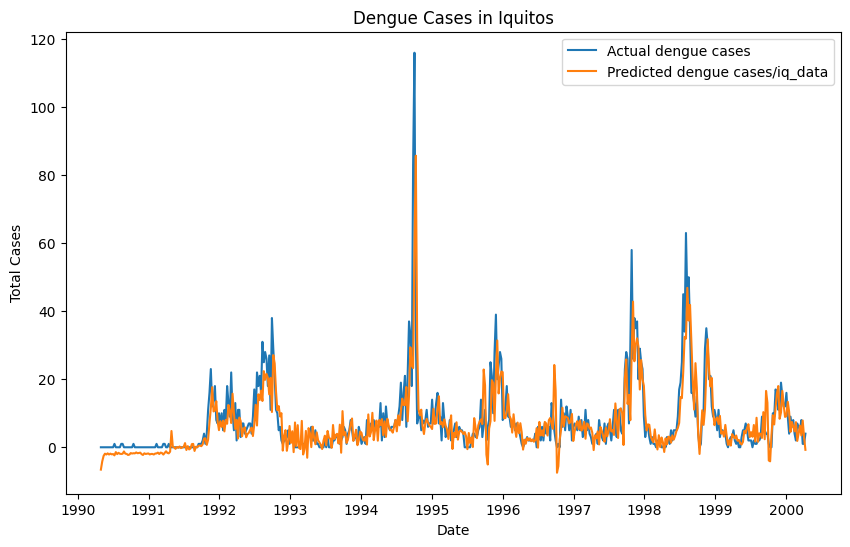

In [ ]:
# Plotting predicted and actual dengue cases from iq_data
plt.figure(figsize=(10, 6))
plt.plot(iq_data.total_cases, label='Actual dengue cases')        # Plot actual values
plt.plot(iq_data_prediction_mean, label='Predicted dengue cases/iq_data')  # Plot predicted values
plt.title('Dengue Cases in Iquitos')                 # Set title
plt.xlabel('Date')                                    # Set x-axis label
plt.ylabel('Total Cases')                             # Set y-axis label
plt.legend()                                          # Show legend
plt.show()                                            # Display plot


Perform prediction for iq_test_data

In [ ]:
iq_test_data.index

DatetimeIndex(['2008-04-29', '2008-05-06', '2008-05-13', '2008-05-20',
               '2008-05-27', '2008-06-03', '2008-06-10', '2008-06-17',
               '2008-06-24', '2008-07-01',
               ...
               '2011-02-15', '2011-02-22', '2011-03-01', '2011-03-08',
               '2011-03-15', '2011-03-22', '2011-03-29', '2011-04-05',
               '2011-04-12', '2011-04-19'],
              dtype='datetime64[ns]', length=156, freq='7D')

In [ ]:
# Define the exogenous variables for future predictions
future_exog = iq_test_data[["precipitation_amt_mm" ,"station_max_temp_c","station_min_temp_c"]]

# Perform prediction for sj_data
iq_test_data_prediction= iq_results.get_forecast(steps=156, exog=future_exog)

# Get the predicted mean for sj_data
iq_test_data_prediction_mean = iq_test_data_prediction.predicted_mean

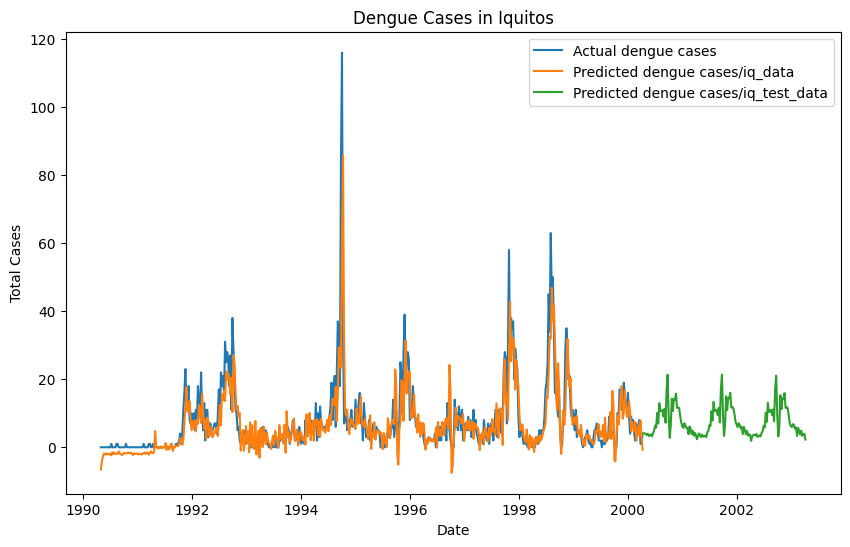

In [ ]:
# Plotting predicted and actual dengue cases from iq_data and iq_test_data
plt.figure(figsize=(10, 6))
plt.plot(iq_data.total_cases, label='Actual dengue cases')        # Plot actual values
plt.plot(iq_data_prediction_mean, label='Predicted dengue cases/iq_data')  # Plot predicted values
plt.plot(iq_test_data_prediction_mean, label='Predicted dengue cases/iq_test_data')
plt.title('Dengue Cases in Iquitos')                 # Set title
plt.xlabel('Date')                                    # Set x-axis label
plt.ylabel('Total Cases')                             # Set y-axis label
plt.legend()                                          # Show legend
plt.show()                                            # Display plot


##Submission

In [ ]:
# Create copies of the original DataFrames
df_submission = submission.copy()
df_submission.head()

total_cases
city year weekofyear             
sj   2008 18                    0
          19                    0
          20                    0
          21                    0
          22                    0

In [ ]:
#import numpy as np
# Concatenate the predicted total cases for San Juan and Iquitos from test data
# predictions and assign it to the 'total_cases' column in df_submission dataframe

df_submission["total_cases"] = np.concatenate([sj_test_data_prediction_mean, iq_test_data_prediction_mean])

df_submission.head()

total_cases
city year weekofyear             
sj   2008 18             9.223755
          19             7.164961
          20             9.078730
          21             8.055570
          22            11.967179

In [ ]:
# Convert the 'total_cases' column to integers
df_submission["total_cases"] = df_submission["total_cases"].astype(int)
df_submission.head(10)

total_cases
city year weekofyear             
sj   2008 18                    9
          19                    7
          20                    9
          21                    8
          22                   11
          23                   11
          24                   11
          25                   16
          26                   17
          27                   18

In [ ]:
# Save the DataFrame to a CSV file named 'Submission_SARIMAX.csv
df_submission.to_csv('Submission_SARIMAX.csv')

 submission score is 25.6490



